In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import xgboost as xgb

There are 32581 rows and 12 features.
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      8195
           1       0.63      0.53      0.58      2230

    accuracy                           0.83     10425
   macro avg       0.76      0.72      0.74     10425
weighted avg       0.83      0.83      0.83     10425

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      7684
           1       0.60      0.88      0.71      2089

    accuracy                           0.85      9773
   macro avg       0.78      0.86      0.81      9773
weighted avg       0.89      0.85      0.86      9773



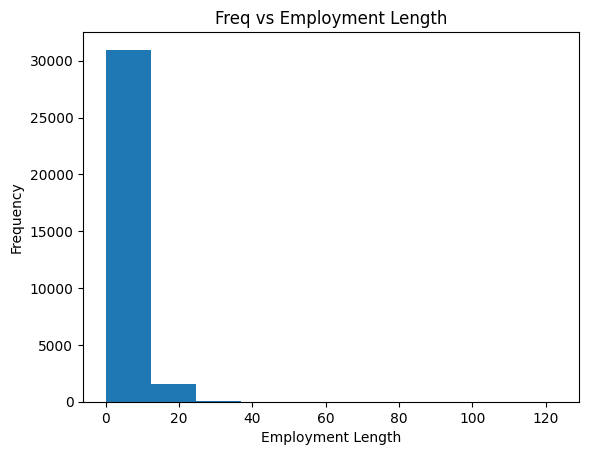

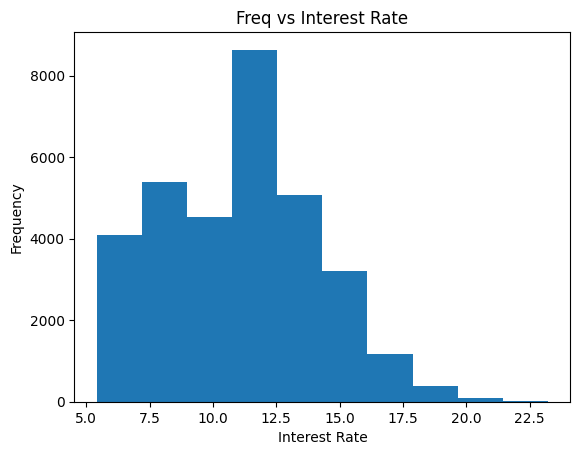

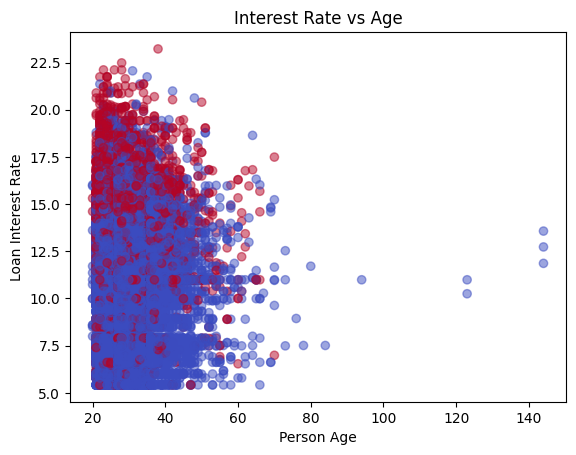

In [39]:
class CreditRiskModel:
    def __init__(self, data_path, n_components=14):
        self.data_path = data_path
        self.data = None
        self.cleaned_data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.y_pred_thres = None
        self.log_preds = None
        self.scaler = MinMaxScaler(feature_range=[0, 1])
        self.pca = PCA(n_components=n_components)
        self.log_model = LogisticRegression()
        self.xgb_model = xgb.XGBClassifier()
    
    def load_data(self):
        self.data = pd.read_csv(self.data_path)
        print(f"There are {self.data.shape[0]} rows and {self.data.shape[1]} features.")
        print(self.data.dtypes)
        return self.data
    
    def clean_data(self):
        self.data = self.data.rename(
            columns={"cb_person_default_on_file": "default_hist",
                     "cb_person_cred_hist_length": "cr_hist_len"})
        
        # Handle missing values
        self.data['person_emp_length'].fillna(self.data['person_emp_length'].median(), inplace=True)
        self.data['loan_int_rate'].fillna(self.data['loan_int_rate'].median(), inplace=True)
        
        # Remove outliers
        self.cleaned_data = self.data[self.data['person_age'] <= 100]

        # One-hot encode categorical variables
        num_col = self.cleaned_data.select_dtypes(exclude='object')
        char_col = self.cleaned_data.select_dtypes(include='object')
        encoded_char_col = pd.get_dummies(char_col)
        self.cleaned_data = pd.concat([num_col, encoded_char_col], axis=1)
        
        return self.cleaned_data
    
    def preprocess_data(self):
        Y = self.cleaned_data['loan_status']
        X = self.cleaned_data.drop(columns=['loan_status'])
        
        # Scale features
        data_rescaled = self.scaler.fit_transform(X)

        # Apply PCA
        pca_dataset = self.pca.fit_transform(data_rescaled)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(pca_dataset, Y, random_state=2020, test_size=0.32)
    
    def train_log_model(self):
        self.log_model.fit(self.X_train, np.ravel(self.y_train))
        y_pred_proba = self.log_model.predict_proba(self.X_test)[:, 1]
        pca_predict_log = pd.DataFrame(y_pred_proba, columns=['prob_default'])
        self.y_pred_thres = pca_predict_log['prob_default'].apply(lambda x: 1 if x > 0.36 else 0)
        self.log_preds = pd.DataFrame(self.y_pred_thres, columns=['log_preds'])
        print(classification_report(self.y_test, self.y_pred_thres))
    
    def preprocess_for_xgb(self):
        Y = self.cleaned_data['loan_status']
        X = self.cleaned_data.drop(columns=['loan_status'])
        
        # Add log_preds as a feature and convert to numerical type
        log_preds_numerical = self.log_preds.astype(int)  # Ensure log_preds is numerical
        X = pd.concat([X.reset_index(drop=True), log_preds_numerical.reset_index(drop=True)], axis=1)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, Y, random_state=2020, test_size=0.30)
    
    def train_xgb_model(self):
        self.xgb_model.fit(self.X_train, np.ravel(self.y_train))
    
    def evaluate_xgb_model(self):
        predict_xgb = self.xgb_model.predict_proba(self.X_test)[:, 1]
        predict_xgb_prob = pd.DataFrame(predict_xgb, columns=['Default Probability'])
        y_pred_thres = predict_xgb_prob['Default Probability'].apply(lambda x: 1 if x > 0.12 else 0)
        print(classification_report(self.y_test, y_pred_thres))
    
    def visualize_data(self):
        plt.hist(self.data['person_emp_length'])
        plt.xlabel("Employment Length")
        plt.ylabel("Frequency")
        plt.title("Freq vs Employment Length")
        plt.show()

        plt.hist(self.data['loan_int_rate'])
        plt.xlabel("Interest Rate")
        plt.ylabel("Frequency")
        plt.title("Freq vs Interest Rate")
        plt.show()

        colors = ["blue", "red"]
        plt.scatter(self.data['person_age'], self.data['loan_int_rate'],
                    c=self.data['loan_status'],
                    cmap=plt.cm.coolwarm, alpha=0.5)
        plt.xlabel("Person Age")
        plt.ylabel("Loan Interest Rate")
        plt.title("Interest Rate vs Age")
        plt.show()

# Usage
credit_model = CreditRiskModel('credit_risk_dataset.csv')
credit_model.load_data()
credit_model.clean_data()
credit_model.preprocess_data()
credit_model.train_log_model()
credit_model.preprocess_for_xgb()
credit_model.train_xgb_model()
credit_model.evaluate_xgb_model()
credit_model.visualize_data()

# Access the final predictions for further use
final_predictions = credit_model.y_pred_thres


In [28]:
#0.25
credit_model.evaluate_xgb_model()

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7684
           1       0.79      0.79      0.79      2089

    accuracy                           0.91      9773
   macro avg       0.87      0.87      0.87      9773
weighted avg       0.91      0.91      0.91      9773



In [36]:
#0.20
credit_model.evaluate_xgb_model()

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      7684
           1       0.74      0.82      0.78      2089

    accuracy                           0.90      9773
   macro avg       0.84      0.87      0.86      9773
weighted avg       0.90      0.90      0.90      9773



In [38]:
#0.15
credit_model.evaluate_xgb_model()

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      7684
           1       0.66      0.86      0.75      2089

    accuracy                           0.88      9773
   macro avg       0.81      0.87      0.83      9773
weighted avg       0.89      0.88      0.88      9773



In [40]:
#0.12
credit_model.evaluate_xgb_model()

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      7684
           1       0.60      0.88      0.71      2089

    accuracy                           0.85      9773
   macro avg       0.78      0.86      0.81      9773
weighted avg       0.89      0.85      0.86      9773

